### GPU 사용 가능 여부 확인

In [1]:
# Identify whether a CUDA-enabled GPU is available
# CUDA GPU 사용 가능 여부 확인
from pathlib import Path
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

CUDA-enabled GPU found. Training should be faster.


### 필요한 라이브러리

In [80]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error


from tqdm import tqdm

import pandas as pd
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids

import matplotlib.pyplot as plt

### 데이터 불러오기

In [15]:
BIDS_ROOT = "/data5/open_data/HBN/EEG_BIDS/"   # ds00505 ~ ds00516 폴더가 들어있는 상위 경로

release_map = {
    "R1": "ds00505",
    "R2": "ds00506",
    "R3": "ds00507",
    "R4": "ds00508",
    "R5": "ds00509",
    "R6": "ds00510",
    "R7": "ds00511",
    "R8": "ds00512",
    "R9": "ds00514",
    "R10": "ds00515",
}

train_releases = ["R1", "R2", "R3", "R4", "R6", "R7", "R8", "R9", "R10"]
val_release = "R5"

In [26]:
# 압축 해제가 다 안돼서 일단 일부 데이터로만

BIDS_ROOT = "/data5/open_data/HBN/EEG_BIDS/"   # ds00505 ~ ds00516 폴더가 들어있는 상위 경로

release_map = {
    "R1": "ds005505",
    "R2": "ds005506",
    "R3": "ds005507",
    "R4": "ds005508",
    "R5": "ds005509",

}

train_releases = ["R1", "R2", "R3", "R4"]
val_release = "R5"

subject level 파일 수집

subject 단위의 폴더를 돌면서 eeg 데이터 불러오기

In [86]:
def collect_subjects(release, task):
    bids_root = os.path.join(BIDS_ROOT, release_map[release])
    eeg_files = glob(os.path.join(
        bids_root, "sub-*", "eeg", f"sub-*_task-{task}_run-*_eeg.set"
    ))
    
    paired_files = []
    for eeg_file in eeg_files:
        events_file = eeg_file.replace("_eeg.set", "_events.tsv")
        if os.path.exists(events_file):
            paired_files.append((eeg_file, events_file))
        else:
            paired_files.append((eeg_file, None))  # 이벤트 파일이 없을 경우 대비
    return paired_files


# Train: SuS
sus_train_files = sum([collect_subjects(r, "surroundSupp") for r in train_releases], [])
# Val: SuS
sus_val_files   = collect_subjects(val_release, "surroundSupp")

# Train: CCD
ccd_train_files = sum([collect_subjects(r, "contrastChangeDetection") for r in train_releases], [])
# Val: CCD
ccd_val_files   = collect_subjects(val_release, "contrastChangeDetection")

print(f"Train SuS: {len(sus_train_files)}, Val SuS: {len(sus_val_files)}")
print(f"Train CCD: {len(ccd_train_files)}, Val CCD: {len(ccd_val_files)}")


Train SuS: 1266, Val SuS: 549
Train CCD: 1738, Val CCD: 745


CCD behavioral labels 읽기

In [82]:
import os
import pandas as pd

def parse_ccd_events(events_tsv):
    """
    CCD events.tsv -> trial별 정보 DataFrame 반환
    - 기준: target onset (left_target, right_target)
    - RT = 첫 buttonPress - target onset
    - success = feedback (smiley_face) 여부
    """
    df = pd.read_csv(events_tsv, sep="\t")
    trials = []
    trial_id = 0

    # run 정보 추출 (파일명에서 run-N 가져오기)
    fname = os.path.basename(events_tsv)
    run = fname.split("run-")[1].split("_")[0]

    # target onset 후보들
    targets = df[df["value"].isin(["left_target", "right_target"])].reset_index(drop=True)

    for _, target in targets.iterrows():
        t_start = target["onset"]

        # target 이후 첫 button press 찾기
        presses = df[(df["onset"] > t_start) & (df["value"].str.contains("buttonPress"))]
        if presses.empty:
            continue
        first_press = presses.iloc[0]
        rt = first_press["onset"] - t_start

        # 성공 여부: target 이후 smiley_face 등장 여부
        feedbacks = df[(df["onset"] > t_start) & (df["value"].str.contains("smiley_face"))]
        success = 1 if not feedbacks.empty else 0

        trials.append({
            "trial_id": trial_id,
            "run": run,
            "target_onset": t_start,
            "response_onset": first_press["onset"],
            "response_time": rt,
            "success": success
        })
        trial_id += 1

    return pd.DataFrame(trials)


### Epoching

In [85]:
import mne


def epoch_sus_trials(eeg_file, events_file, tmin=-0.2, tmax=0.5):
    """
    SuS EEG trial을 epoching하고 background+foreground_contrast 값을 반환
    """
    # EEG 불러오기
    raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
    events_df = pd.read_csv(events_file, sep="\t")
    
    # stim_on 이벤트만 선택
    stim_events = events_df[events_df["value"] == "stim_on"].reset_index(drop=True)
    
    # epoch용 event array 생성
    mne_events = []
    for _, row in stim_events.iterrows():
        onset_sample = int(row["onset"] * raw.info["sfreq"])
        mne_events.append([onset_sample, 0, 1])  # 1 = stim_on
    
    mne_events = np.array(mne_events)
    
    # MNE Epochs
    epochs = mne.Epochs(
        raw, mne_events, event_id={"stim_on": 1},
        tmin=tmin, tmax=tmax, baseline=(tmin, 0),
        detrend=1, preload=True
    )
    
    X = epochs.get_data()  # (n_trials, n_channels, n_times)
    
    # contrast 정보 계산
    contrasts = []
    for _, row in stim_events.iterrows():
        bg = row.get("background_contrast", 0.0)
        fg = row.get("foreground_contrast", 0.0)
        contrasts.append(bg + fg)
    
    contrasts = np.array(contrasts)  # (n_trials,)
    
    return X, contrasts


### SuS, CCD 매칭

In [37]:
def match_trials(sus_file, ccd_file):
    sus_epochs, sus_meta = load_sus_epochs_trials(sus_file)
    if sus_epochs is None:
        return None, None
    events_tsv = ccd_file.replace("_eeg.set", "_events.tsv")
    ccd_labels = parse_ccd_events(events_tsv)
    if ccd_labels is None or len(ccd_labels) == 0:
        return None, None

    df = pd.merge(sus_meta, ccd_labels, on=["run", "trial_id"], how="inner")
    X = sus_epochs.get_data()[:len(df)]
    y = df[["response_time", "success"]].values
    return X, y


### Dataset 정의

In [43]:
from torch.utils.data import Dataset

def get_subject_id(eeg_file):
    return eeg_file.split("sub-")[1].split("_")[0]

class SuSToCCDTrial(Dataset):
    def __init__(self, sus_files, ccd_files, subjects):
        self.samples = []
        for subj in subjects:
            if subj not in sus_files or subj not in ccd_files:
                continue
            X, y = match_trials(sus_files[subj], ccd_files[subj])
            if X is not None:
                for xi, yi in zip(X, y):
                    self.samples.append((xi, yi))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        X, y = self.samples[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [40]:
def get_subject_id(eeg_file):
    # 상위 디렉토리 이름 (= sub-XXXX)
    return os.path.basename(os.path.dirname(eeg_file)).replace("sub-", "")


In [46]:
# Train
sus_dict = {get_subject_id(f): f for f in sus_train_files}
ccd_dict = {get_subject_id(f): f for f in ccd_train_files}
train_subjects = sorted(set(sus_dict.keys()) & set(ccd_dict.keys()))
train_dataset = SuSToCCDTrial(sus_dict, ccd_dict, train_subjects)

# Validation
sus_val_dict = {get_subject_id(f): f for f in sus_val_files}
ccd_val_dict = {get_subject_id(f): f for f in ccd_val_files}
val_subjects = sorted(set(sus_val_dict.keys()) & set(ccd_val_dict.keys()))
val_dataset = SuSToCCDTrial(sus_val_dict, ccd_val_dict, val_subjects)

print(f"Train subjects: {len(train_subjects)}, Val subjects: {len(val_subjects)}")
print(f"Train trials: {len(train_dataset)}, Val trials: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'contrastChangeB3_start', 'contrastTrial_start', 'dot_no2_ON', 'dot_no3_ON', 'fixpoint_ON', 'right_target', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['contrastTrial_start', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break 

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descripti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['break cnt', 'contrastChangeB1_start', 'contrastTrial_start', 'dot_no2_ON', 'dot_no3_ON', 'fixpoint_ON', 'right_target', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad ep

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7 events and 1001 original time points ...
1 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'br

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epoc

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['break cnt', 'fixpoint_ON', 'stim_ON', 'surr

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'br

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break 

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epoc

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epoc

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'contrastTrial_start', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'br

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
/home/RA/.local/lib/python3.10/site-packages/pymatreader/utils.py:296: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', '

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epoc

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'br

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epoc

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break 

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations d

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epoc

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start', 'video_start', 'video_stop']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', '

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'sti

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'f

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt'

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'f

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt'

/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['9999', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB2_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Used Annotations descriptions: ['boundary', 'break cnt', 'fixpoint_ON', 'stim_ON', 'surroundSuppB1_start']
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 64 events and 1001 original time points ...
0 bad epochs dropped


/tmp/ipykernel_3057346/2493430017.py:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Train subjects: 605, Val subjects: 257
Train trials: 6461, Val trials: 2105


In [47]:
print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_loader)}")
print(f"Valid:\t{len(val_loader)}")

Number of examples in each split in the minirelease
Train:	202
Valid:	66


In [62]:
X, y = next(iter(train_loader))
print("Batch X shape:", X.shape)  # (batch_size, chans, times)
print("Batch y shape:", y.shape)  # (batch_size, labels)


Batch X shape: torch.Size([32, 129, 1001])
Batch y shape: torch.Size([32, 2])


### 모델 정의

In [72]:
class EEGNeX_Custom(nn.Module):
    def __init__(self, n_chans, n_times, feat_dim=128):
        super().__init__()
        # Temporal conv
        self.temporal = nn.Conv1d(n_chans, 64, kernel_size=15, padding=7)
        self.bn1 = nn.BatchNorm1d(64)

        # Depthwise conv
        self.depthwise = nn.Conv1d(64, 64, kernel_size=15, padding=7, groups=64)
        self.pointwise = nn.Conv1d(64, 128, kernel_size=1)

        # Residual
        self.residual = nn.Conv1d(n_chans, 128, kernel_size=1)

        # Channel attention (SE block)
        self.se_fc1 = nn.Linear(128, 32)
        self.se_fc2 = nn.Linear(32, 128)

        # Pooling
        self.pool = nn.AdaptiveAvgPool1d(50)

        # Fully connected feature extractor
        self.fc = nn.Linear(128*50, feat_dim)

        # Regression head (RT only)
        self.fc_rt = nn.Linear(feat_dim, 1)

    def forward(self, x):
        # Input: (B, chans, time)
        out = torch.relu(self.bn1(self.temporal(x)))   # (B, 64, T)

        out = self.pointwise(self.depthwise(out))      # (B, 128, T)

        # Residual connection
        res = self.residual(x)                         # (B, 128, T)
        out = out + res

        # Channel attention (SE block)
        w = torch.mean(out, dim=2)                     # (B, 128)
        w = torch.relu(self.se_fc1(w))
        w = torch.sigmoid(self.se_fc2(w)).unsqueeze(2) # (B, 128, 1)
        out = out * w

        # Pooling & Flatten
        out = self.pool(out)                           # (B, 128, 50)
        out = out.flatten(start_dim=1)                 # (B, 128*50)

        feat = torch.relu(self.fc(out))                # (B, feat_dim)
        rt = self.fc_rt(feat)                          # (B, 1)

        return rt


In [73]:
# DataLoader에서 실제 shape 확인
X, y = next(iter(train_loader))
n_chans, n_times = X.shape[1], X.shape[2]
print(f"Detected n_chans={n_chans}, n_times={n_times}")

# 모델 초기화
model = EEGNeX_Custom(n_chans=n_chans, n_times=n_times).to(device)

# 더미 테스트
with torch.no_grad():
    out = model(X.to(device))
    print("Output shape:", out.shape)  # (B, 1) 이어야 정상


Detected n_chans=129, n_times=1001
Output shape: torch.Size([32, 1])


### 학습 루프 정의

In [78]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses, val_nrmse = [], [], []
n_epochs = 10

for epoch in range(n_epochs):
    # -------------------
    # Train
    # -------------------
    model.train()
    total_loss = 0.0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
        X = X.to(device)
        rt_target = y[:,0].unsqueeze(1).float().to(device)

        rt_pred = model(X)
        loss = criterion(rt_pred, rt_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    total_val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            rt_target = y[:,0].unsqueeze(1).float().to(device)
            rt_out = model(X)

            # MSE Loss 기록
            vloss = criterion(rt_out, rt_target)
            total_val_loss += vloss.item()

            # nRMSE 계산용
            y_true.extend(rt_target.cpu().numpy())
            y_pred.extend(rt_out.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # nRMSE (리포트용)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = mean_squared_error(y_true, y_pred)**1/2
    nrmse = rmse / np.std(y_true)
    val_nrmse.append(nrmse)

    print(f"Epoch {epoch+1}/{n_epochs} - Train MSE: {avg_loss:.4f}, Val MSE: {avg_val_loss:.4f}, Val nRMSE: {nrmse:.4f}")


Epoch 1/10 - Train MSE: 615.3153, Val MSE: 26.3027, Val nRMSE: 2.6091


Epoch 2/10 - Train MSE: 624.5350, Val MSE: 35.2966, Val nRMSE: 3.5024


Epoch 3/10 - Train MSE: 622.1150, Val MSE: 35.8479, Val nRMSE: 3.5586


Epoch 4/10 - Train MSE: 617.2494, Val MSE: 31.3768, Val nRMSE: 3.1139


Epoch 5/10 - Train MSE: 622.2485, Val MSE: 46.3785, Val nRMSE: 4.6052


Epoch 6/10 - Train MSE: 621.5118, Val MSE: 29.3454, Val nRMSE: 2.9118


Epoch 7/10 - Train MSE: 611.7417, Val MSE: 38.9174, Val nRMSE: 3.8639


Epoch 8/10 - Train MSE: 616.5618, Val MSE: 29.3741, Val nRMSE: 2.9144


Epoch 9/10 - Train MSE: 616.1524, Val MSE: 28.8913, Val nRMSE: 2.8666


Epoch 10/10 - Train MSE: 612.8352, Val MSE: 36.6837, Val nRMSE: 3.6419


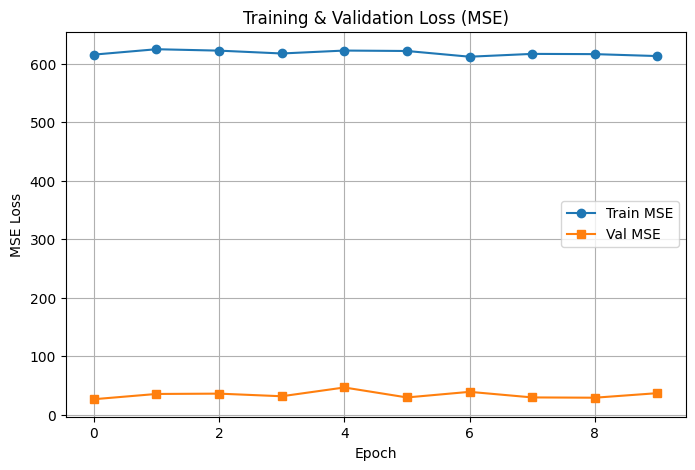

In [79]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train MSE", marker="o")
plt.plot(val_losses, label="Val MSE", marker="s")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# saving the model

torch.save(model.state_dict(), "model.pth")
